Some usage examples. Requires a trajectory (preferrable xtc or dcd format) and pdb (or alternative topology).

In [33]:
from src import *
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

/Users/kebl8116-admin/Projects/protein_folding_graphs/src/graph_analysis.py:190: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if physics is "kinetic": # Most Probable Path (Kinetic)
/Users/kebl8116-admin/Projects/protein_folding_graphs/src/graph_analysis.py:198: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif physics is "thermodynamic": # Min Free Energy Barrier Path (Thermodynamic)


First let's construct and plot a temporal adjacency graph

Frames: 10001 N: 10 Unique maps: 362


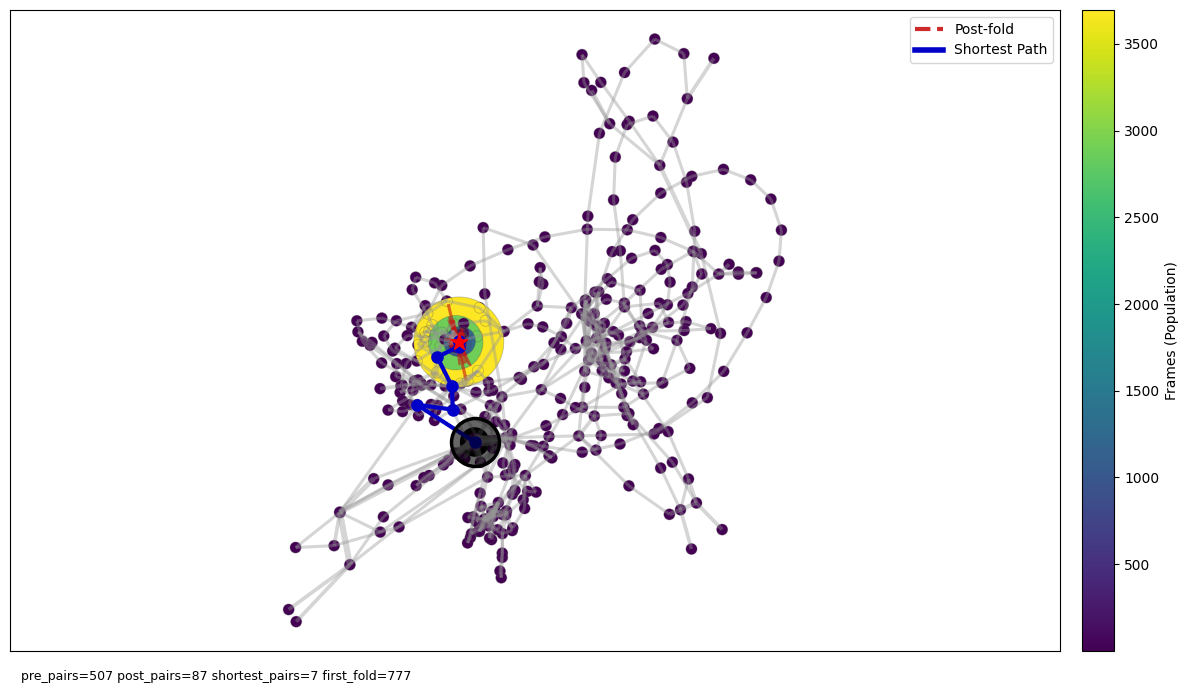

In [ ]:
#pdb = "" # your pdb file here
#xtc = "" # your trajectory here
pdb = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.pdb"
xtc = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.xtc"

# gets contact maps (N,N) for each frame F in trajectory -> (F,N,N)
contact_maps = contacts.get_contact_maps(top=pdb, traj=xtc) # backend is MDAnalaysis so can provide universe instead
# extract list of unique contact maps (N,N)
unique_maps, frame_to_uid, inds = contacts.get_unique_maps(contact_maps)
# frame_to_uid is a list of unique contact map (or node) ids 
# (from 0 to n unique contact maps) for each frame in trajectory
# inds is list of the frame indexes in the trajectory of the first appearance of each contact map

# build a graph whose edges represent temporal adjacency
G, counter, node_counts = graphs.build_temporal_transition_graph(frame_to_uid, inds, keep_self_loops=False)
# plot it as a static image with edges weighted by transitions counts
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=True,
                                   title="")
plt.show()

For a contact space manifold graph we get bit representations of contact maps for hamming distance comparison to determine manifold edges

In [ ]:
# convert unique maps to bit integer representations instead of N,N contact map matrices
# ints is the list of unique contact map bit integers for each frame in trajectory
ints, Mbits, _ = contacts.maps_to_upper_ints(unique_maps)

# build graph with edges representing hamming difference of 1
# so connect nodes that are adjacent in the contact space manifold (1 contact flip apart)
Gm, ints = graphs.build_contact_manifold_graph(ints, Mbits, method='auto')

# get node counts as contact map state populations
U = int(np.max(frame_to_uid)) + 1
node_counts = np.bincount(frame_to_uid, minlength=U)

# then collect temporal edges and transition count information
edge_info = graphs.temporal_edge_counts(frame_to_uid, keep_self_loops=False)

# now merge manifold and temporal graphs
G = graphs.merge_manifold_and_temporal(Gm, edge_info, node_counts=node_counts) # and merge

start_node = int(frame_to_uid[0]) # assume start node is first
folded_node = int(np.argmax(np.bincount(frame_to_uid))) # and folded node most populated

# shortest path along manifold graph only (Gm)
# could provide G instead to get shortest path operating on manifold and temporal edges
path_m = nx.shortest_path(Gm, source=start_node, target=folded_node)
# custom path overlays
custom_paths = {
    'Manifold Geodesic': path_m
}

# this plotting function by default plots the shortest path over manifold+temporal edges (blue)
# with above custom_paths with path_m we ad violet manifold geodesic path
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=True,
                                   custom_paths=custom_paths,
                                   title="")
plt.show()


For the plotting coordinates to be meaningful in the contact map space we must embed the high dimensional N,N (or compressed bit/integer representations which still live on the hypercube) maps to 2D

In [ ]:
# flatten unique N,N contact maps upper triangles to flat bits and convert to integer representations
flat_bits, _, Mbits = contacts.flatten_upper_bits(unique_maps) # we get the actual bits here for later use
ints, Mbits, _ = contacts.maps_to_upper_ints(unique_maps) # and also use this function which uses the above then converts the flat bits into ints

# construct the manifold graph from ints representation
Gm, ints = graphs.build_contact_manifold_graph(ints, Mbits, method='auto')
# again merge the temporal edge infos
edge_info = graphs.temporal_edge_counts(frame_to_uid, keep_self_loops=False)
G = graphs.merge_manifold_and_temporal(Gm, edge_info, node_counts=node_counts)

# now we perform the embedding with the flattened bits (not integers)
# using pca followed by umap
X_emb, pca = clustering.embed_flat_bits(flat_bits, pca_n=45, umap_n=2)

# we can extract x, y positions from the first embeddings
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}

# plot
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, pos, X_emb, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=False,
                                   custom_paths=custom_paths,
                                   title="")
plt.show()

Same as above but instead use MDS embedding for more maningful geometric distances.

In [ ]:
# embedd int representations by MDS
X_emb, labels, D = clustering.embed_and_cluster_by_hamming(ints,
                                 n_components=10,
                                 embed_method='mds',   # 'mds' or 'spectral'
                                 cluster_method='agglomerative',  # 'agglomerative' or 'hdbscan'
                                 n_clusters=None,      # only for agglomerative
                                 random_state=42,
                                 warn_threshold=4000)
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}

fig, ax = plotting.plot_graph_auto(G, frame_to_uid, pos, X_emb, unique_maps=unique_maps, unique_indices=inds, interactive=False,
                                   custom_paths=custom_paths,
                                   title="")
plt.show()

What about physics based graphs?

In [ ]:
'''
PHYSICS GRAPHS with shortest paths NOT restricted to manifold edges
'''
start_node = int(frame_to_uid[0])
folded_node = int(np.argmax(np.bincount(frame_to_uid)))

# kinetic method based on transition probabilities
G_kinetic = graph_analysis.build_physics_graph(G, physics_mode="kinetic", 
                            restrict_to_manifold=True, 
                            frame_to_uid=frame_to_uid)
path_kinetic = nx.shortest_path(G_kinetic, source=start_node, target=folded_node, weight='weight')

# thermodynamic method based on Boltzmann Inversion
G_therm = graph_analysis.build_physics_graph(G, physics_mode="thermodynamic", 
                            restrict_to_manifold=True, 
                            frame_to_uid=frame_to_uid)
path_therm = nx.shortest_path(G_therm, source=start_node, target=folded_node, weight='weight')

# paths for plotting
custom_paths = {
    "Manifold Geodesic": path_m,
    "Kinetic Path": path_kinetic,
    "Thermodynamic Path": path_therm
}

# Let's actually compute proper free energies with a MSM approach
MSM = graph_analysis.markov_state_model(G)

true_folded_node = MSM['folded_node'] # this gives us a physics-based approximation of the true folded node

F_map = MSM['free_energy'] # free energies for each node
nx.set_node_attributes(G, F_map, 'free_energy')

# Map F values to the embedding
num_nodes = X_emb.shape[0]
f_colors = [F_map.get(i, 10.0) for i in range(num_nodes)] # Default high energy if missing


fig, ax = plotting.plot_graph_auto(
    G_kinetic, frame_to_uid, pos=pos, X_emb=X_emb,
    unique_maps=unique_maps,
    unique_indices=inds,
    start_frame=start_node,
    folded_node=true_folded_node,
    show_shortest=True,
    show_bg=False,
    custom_paths=custom_paths,
    custom_paths_colors=[(180/255, 20/255, 220/255, 1.0), (1.0, 0.6, 0, 1.0), (0.2, 1.0, 0, 1.0)],
    node_custom_color=f_colors,
    node_custom_color_title="Free energy",
    palette="viridis_r",  
    interactive=False,
    title=""
)
plt.show()

Plotting on reaction coordinates and free energy (x,y) instead of embeddings

In [ ]:
import pandas as pd 
from matplotlib.collections import LineCollection

node_counts = pd.Series(frame_to_uid).value_counts()
node_list = list(G.nodes())

# compute committor probabilities for each node
q_map = graph_analysis.compute_committor(G, start_node, folded_node, use_direct_solver=True)
nx.set_node_attributes(G, q_map, 'committor')
# translate into node colours
node_q_colors = [G.nodes[i].get('committor', 0.0) for i in range(len(G.nodes()))]

custom_paths_colors=[(180/255, 20/255, 220/255, 1.0), (1.0, 0.6, 0, 1.0), (0.2, 1.0, 0, 1.0)]

# and node sizes by frame counts
frame_counts = plotting.ensure_frame_counts(G, frame_to_uid)
max_node_size = 500
min_node_size = 40
node_sizes = min_node_size + (frame_counts / max(1, frame_counts.max())) * (max_node_size - min_node_size)

fig, ax = plotting.plot_energy_landscape(G, q_map, F_map, custom_paths=custom_paths, custom_paths_colors=custom_paths_colors, folded_node=folded_node,
    node_sizes=node_sizes
)
plt.show()

Estimate transition state ensemble with committor probabilities

In [ ]:
# TSE is defined as states with q approx 0.5 (0.4 to 0.6)
tse_nodes = [n for n, q in q_map.items() if 0.4 <= q <= 0.6]
print("TSE: ", tse_nodes)

Finally let's determine the contact flip kinetic barriers

In [ ]:
G_energy, df, results = contact_energies.infer_contact_flip_energies_from_graph(G, ints=ints, node_state_attr=G.nodes, Gm=Gm)
print(df)

res_pairs_native = np.argwhere(np.triu(contact_maps[-1], k=1) == 1)
N = contact_maps.shape[1]

contact_energies_matrix = np.full((N,N), np.nan, dtype=float)
for native_pair in res_pairs_native:
    i, j = native_pair
    try:
        contact_energies_matrix[i, j] = df.loc[df['residue_pair'] == native_pair, 'dG_rel_kcal_per_mol'].iloc[0]
        contact_energies_matrix[j, i] = df.loc[df['residue_pair'] == native_pair, 'dG_rel_kcal_per_mol'].iloc[0]
    except:
        print(native_pair, "not found in df_contacts")
        contact_energies_matrix[i, j] = np.nan
        contact_energies_matrix[j, i] = np.nan

import seaborn as sns
plt.figure(figsize=(6, 5))
ax = sns.heatmap(contact_energies_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0,
    cbar=True
)
ax.invert_yaxis()

# Turn ON only the outer axes box
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1.5)

plt.title("Chignolin Relative Contact Flip Energy dG (kcal/mol)")
plt.ylabel("Residue Index")
plt.xlabel("Residue Index")
plt.tight_layout()
plt.show()